In [111]:
import os
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions
from   astropy.coordinates   import SkyCoord
from   astropy.table         import Table
from   pathlib               import Path

In [112]:
from   desimodel.focalplane  import get_tile_radius_deg 

Potential addition: 'Stars were removed from the sample used to compute the number counts using SExtractor’s CLASS_STAR parameter with a threshold of 0.85'

In [113]:
def get_hildebrandt(field='D2'):
    # SXDS:  (02:18:00.00, −05:00:00.00), D1 encompassed by W1.  
    return  Table.read('/global/cscratch1/sd/mjwilson/DESILBG/Hildebrandt/{}.cat'.format(field))

In [114]:
def get_goldrush():
    # https://arxiv.org/pdf/1704.06004.pdf
    dat   = Table.read('/global/homes/m/mjwilson/DESILBG/target/proposals/goldrush/goldrush_mizukizs.fits')    
    
    return dat

In [115]:
def get_laes():
    # https://arxiv.org/pdf/0801.4017.pdf
    dat   = pd.read_csv('/global/homes/m/mjwilson/DESILBG/target/proposals/sxds_laes.txt', sep='\s+', comment='#')
    
    dat.drop(dat.columns[list(np.arange(7, 20, 1))], axis=1, inplace=True)
    
    dat.columns = ['Row', 'Name', 'RA', 'DEC', 'None', 'Velocity', 'Redshift']
    dat['RA']   = [Angle(x).deg for x in dat['RA']]
    dat['DEC']  = [Angle(x[:-1] + '.0s').deg for x in dat['DEC']]
    
    return  dat

In [116]:
def get_vvds():
    # https://cesam.lam.fr/vvds/vvds_download.php
    dat = pd.read_csv('/global/cscratch1/sd/mjwilson/VVDS/cesam_vvds_spF02_DEEP_Full.txt', sep='\s+')

    # Cut.
    dat = dat[dat['Z'] < 9.0]
    
    return dat

In [117]:
def get_splash():
    dat = Table.read('/global/cscratch1/sd/mjwilson/SPLASH/SPLASH_SXDF_Mehta+_v1.6.fits')
    
    return dat

In [118]:
def get_clauds(imaging_bit=1, field='COSMOS'):
    fields           = ['COSMOS', 'DEEP_2', 'ELAIS', 'XMM_LSS']
    clauds           = {}
        
    assert field in fields
        
    areas            = {}
    areas['COSMOS']  = {'u': 4.41, 'uS': 4.20, 'g': 7.84,  'r': 7.84,  'i': 7.84,  'z': 7.84,  'y': 7.84}
    areas['XMM-LSS'] = {'u': 0.00, 'uS': 6.80, 'g': 6.38,  'r': 6.38,  'i': 6.38,  'z': 6.38,  'y': 6.38}
    areas['DEEP2-3'] = {'u': 3.70, 'uS': 0.00, 'g': 6.11,  'r': 6.11,  'i': 6.11,  'z': 6.11,  'y': 6.11}
    areas['ELAIS-N'] = {'u': 6.49, 'uS': 0.00, 'g': 10.68, 'r': 10.68, 'i': 10.68, 'z': 10.68, 'y': 10.68}

    for key in areas.keys():
        if imaging_bit == 1:
            del areas[key]['uS']
    
        elif imaging_bit == 2:
            del areas[key]['u']
    
    clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/October2020/{}_v3_v201026.fits'.format(field))
    
    # Bright star mask & has newer u band data: [HSC, u, Us, J, VirCAM, UDEEP] for FLAG_FIELD_BINARY (imaging_bit). 
    clauds[field] = clauds[field][(clauds[field]['MASK'] == 0) & clauds[field]['FLAG_FIELD_BINARY'][:,imaging_bit] == True]
    
    return  clauds[field], areas[field]

In [119]:
tile_radius = get_tile_radius_deg()
tiles       = Table(io.load_tiles())

In [10]:
# hiz  = laigle()

In [11]:
# kids = get_kids()

In [12]:
# splash = get_splash()

In [13]:
# splash_zspec = splash[splash['ZSPEC'] > 0.]

In [14]:
# hilde  = get_hildebrandt()

In [15]:
# grush  = get_goldrush()

In [16]:
# laes   = get_laes()

In [17]:
# cfhtls = get_cfhtls_wide()

In [18]:
# vvds   = get_vvds()

In [120]:
clauds, area = get_clauds(imaging_bit=1, field='COSMOS')

In [121]:
clauds

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
0,149.59750039856772,2.878867531391069,10054,"0,0",0,7,True .. False,5.983199e-05,4.2390246e-05,0.0,18.707382,1.411474,0.29152077,0.01650220434314842,0.00010493658,26.313028,0.35052329301834106,0.90521127,1.1155249,1.290297,28.618,28.469,28.224,28.454,28.143,27.342,-99.021,-99.02,-99.014,-99.009,-99.006,0.321,0.396,0.228,0.409,0.366,0.284,-99.0,-99.0,-99.0,-99.0,-99.0,28.174038,28.644983,28.512594,28.279272,29.47153,28.575283,99.0,1e+20,1e+20,1e+20,1e+20,0.28810936,0.6316033,0.40882772,0.48986953,1.7506987,1.2607428,99.0,1e+20,1e+20,1e+20,1e+20,63.0,-15.932,-15.841,-17.297,-17.537,-18.373,-18.848,-19.151,-19.347,-19.436,-19.465,-19.551,-19.735,-19.507,-99.0,1.3113,0.2992,2.4572,6,0.34828,2.74895,0.441968,26,242,18,1.5941,0.9272,2.2318,-99.0,1.88,12,3000000000.0,0.1,1,876443000.0,8.44477,9.20917,7.81413,9.03823,-0.425113,-0.824061,-0.894037,0.139983,-8.87912,-10.0332,-9.42886,-8.10284,8.151,8.5744,7.88058,0.0,0,1.5941
1,149.54307792888886,2.878899117842753,10054,"0,0",0,7,True .. False,9.388733e-05,4.5947952e-05,4.0,-4.1316705,2.0431647,0.51056325,0.016291514813532786,0.0003912516,25.518118,0.3872963190078736,0.9483222,1.2461437,1.4747574,27.574,28.053,28.085,27.543,26.89,26.906,26.839,-99.02,-99.014,-99.009,-99.006,0.123,0.259,0.198,0.173,0.114,0.186,0.371,-99.0,-99.0,-99.0,-99.0,27.541115,27.956047,27.778364,27.591347,26.928577,26.81956,27.107319,1e+20,1e+20,1e+20,1e+20,0.17674026,0.3514954,0.22487052,0.2763569,0.18269701,0.26761687,0.7439933,1e+20,1e+20,1e+20,1e+20,127.0,-15.423,-14.97,-15.817,-15.93,-16.142,-16.154,-16.172,-16.226,-16.245,-16.234,-16.149,-16.174,-15.916,-99.0,0.7557,0.6459,0.9068,7,2.46672,22.4587,3.58548,27,48,29,0.8746,0.6589,1.2486,-99.0,0.2,10,321031000.0,0.0,0,1198660000.0,7.7489,7.5288,7.45523,8.04443,-1.27257,-1.68193,-1.4498,-0.789413,-9.02023,-9.21073,-9.43064,-8.31573,7.50047,7.48196,6.54335,0.0,0,0.8746
2,149.51906824547063,2.878

In [122]:
print('Target density of clauds galaxies per sq. deg. is {:.2f}'.format(len(clauds) / area['u']))

Target density of clauds galaxies per sq. deg. is 585624.94


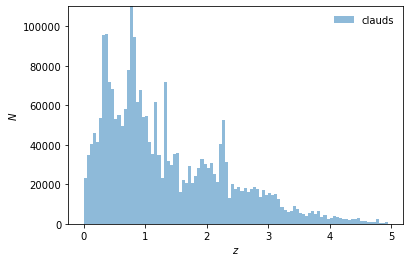

In [123]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(clauds['Z_BEST'], bins=bins, alpha=0.5, label='clauds')

pl.ylim(0.0, 1.1e5)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [124]:
isin, indx = is_point_in_desi(tiles, clauds['RA'], clauds['DEC'], radius=None, return_tile_index=True)

In [125]:
tileids = np.unique(indx)

In [126]:
tileids

array([  828,  2826,  3754,  5656,  5752,  5753,  7750, 11747, 13744,
       13745])

In [127]:
# u-band imaging restricted.
cra      = np.median(clauds['RA'])
cdec     = np.median(clauds['DEC'])

trad     = tile_radius

In [128]:
# (10:00:59.50, 02:13:53.06)
hsc_cosmos = SkyCoord('10h00m59.5s', '+02d13m53.06s', frame='icrs')

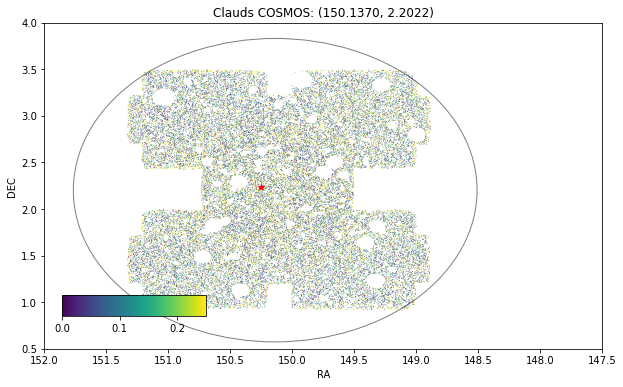

In [129]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(clauds['RA'][::50], clauds['DEC'][::50], c=clauds['u_err'][::50], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

pl.scatter(hsc_cosmos.ra.deg, hsc_cosmos.dec.deg, marker='*', c='r')

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

pl.savefig('clauds_field.pdf')

In [130]:
def liu_udrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    u-drop color selection.
    '''

    # Check these targets have u band imaging available. 
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,1] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    
    isin = isin & (clauds['u'] - clauds['g'] > 0.88)
    isin = isin & (clauds['u'] - clauds['g'] > 1.99 * (clauds['g'] - clauds['r']) + 0.68)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    # Catch -99 for ill defined magnitudes
    isin = isin & (clauds['u'] > 0.0)
    isin = isin & (clauds['g'] > 0.0)
    
    return  isin

In [131]:
def hilde_usdrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    uS-drop color selection.
    '''
    
    # Check these targets have uS band imaging available.
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,2] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    isin = isin & (clauds['uS'] - clauds['g'] > 0.90)
    isin = isin & (clauds['uS'] - clauds['g'] > 1.50 * (clauds['g'] - clauds['r']) + 0.75)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    return  isin

In [132]:
udrops    = clauds[liu_udrops(clauds)]

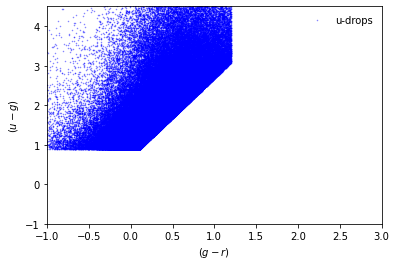

In [133]:
pl.plot(udrops['g'] - udrops['r'], udrops['u'] - udrops['g'], marker='.', c='b', lw=0.0, label='u-drops', alpha=0.5, markersize=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.legend(frameon=False)

pl.savefig('clauds-udrop-color-selection.pdf')

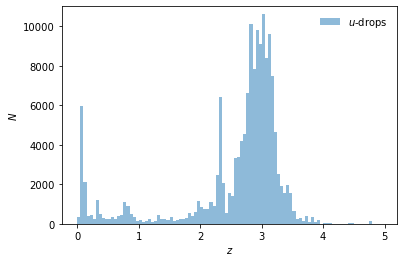

In [134]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(udrops['Z_BEST'], bins=bins, alpha=0.5, label='$u$-drops')

pl.ylim(0.0, 1.1e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [88]:
zmax       = 1.5
interloper = udrops[udrops['Z_BEST'] < zmax]
highz      = udrops[udrops['Z_BEST'] > zmax]

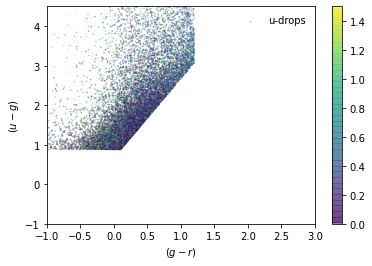

In [89]:
pl.scatter(interloper['g'] - interloper['r'], interloper['u'] - interloper['g'], marker='.', c=interloper['Z_BEST'], alpha=0.5, label='u-drops', vmin=0.0, vmax=zmax, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

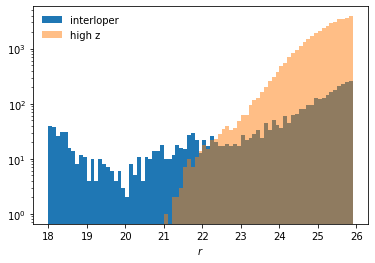

In [90]:
bins = np.arange(18., 26., 0.1)

pl.hist(interloper['r'], bins=bins, label='interloper')
pl.hist(     highz['r'], bins=bins, alpha=0.5, label='high z')

pl.yscale('log')

pl.xlabel(r'$r$')

pl.legend(frameon=False)

In [135]:
rlim_udrops = clauds[liu_udrops(clauds, band='r', magmin=19., maglim=26.)]

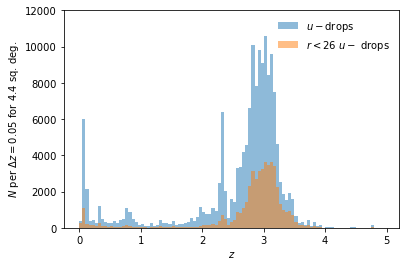

In [136]:
dz          = 0.05
bins        = np.arange(0.0, 5.0, dz)

pl.hist(udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$u-$drops')
pl.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$ drops')

pl.ylim(0.0, 1.2e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

pl.legend(frameon=False)

pl.savefig('clauds-udrop-redshift-distribution.pdf')

In [137]:
print('Target density of u-dropouts per sq. deg. is {:.2f}'.format(len(rlim_udrops) / area['u']))

Target density of u-dropouts per sq. deg. is 11001.59


In [138]:
print('u-dropout interloper percentage of {:.3f}'.format(100. * np.count_nonzero(rlim_udrops['ZPHOT'] < 0.1) / len(rlim_udrops)))

u-dropout interloper percentage of 1.451


In [139]:
def flatmagcat(maglimcat, band, maglim=26.01, debug=False):
    bins       = np.arange(20., maglim, 0.1)
    
    assert  maglimcat[band].max() <= maglim
    
    result     = np.histogram(maglimcat[band], bins=bins)

    cnts, bins = result[0], result[1]
    lims       = bins[:-1]
     
    cut        = cnts > 0.25 * np.median(cnts[cnts > 0])
    cutlim     = lims[cut][0]
        
    magsampling                    = cnts / cnts[cut][0]    
    magsampling[(magsampling < 1.) & (bins[:-1] < cutlim)] = 1.0
    
    if debug:
        print(magsampling)
    
    magsampling                    = 1. / magsampling
        
    magsampling                = np.concatenate((magsampling, np.array([0])))
        
    indx                       = np.digitize(maglimcat[band], bins)
    
    sampling                   = np.random.uniform(0.0, 1.0, len(maglimcat))
    
    maglimcat['ISIN']          = sampling < magsampling[indx]
        
    # In, residual.
    return  cutlim, maglimcat[maglimcat['ISIN']], maglimcat[~maglimcat['ISIN']]

In [140]:
def qa(tiers, band):
    upriority, cnts = np.unique(tiers['PRIORITY'].data, return_counts=True)

    for p, c in zip(upriority[::-1], cnts[::-1]):
        meanmag     = np.mean(tiers[tiers['PRIORITY'] == p][band])
        meanz       = np.mean(tiers[tiers['PRIORITY'] == p]['Z_BEST'])
        
        print('{: 10d} \t {: 10d} \t {:.2f} \t {:.2f}'.format(p, c, meanmag, meanz))

In [147]:
def reduce(start_id, inputcat, band, ttype, maglim=26.1, levels=10, write=False, debug=False):
    bins = np.arange(18., maglim, 0.1)
    result = pl.hist(inputcat[band], bins=bins, alpha=0.3)
    reducecat = Table(inputcat, copy=True)

    tiers = Table()
    total =  0

    for i in np.arange(levels):    
        priority                = 1000 * (levels - i)
        
        cutlim, flat_drops, reducecat = flatmagcat(reducecat, band, debug=debug, maglim=maglim)
        
        flat_drops['PRIORITY'] = priority
                    
        tiers                   = vstack((tiers, flat_drops))
    
        total                  += len(flat_drops)
    
        string = '{:.1f} \t {} \t {:d}'.format(cutlim, len(np.unique(tiers['PRIORITY'].data)), np.count_nonzero(tiers['PRIORITY'] == priority))

        # Reshuffle such that there's a max of 1000 to a priority class.
        # Move remaining to a lower tier.
        if np.count_nonzero(tiers['PRIORITY'] == priority) > 1000:
            is_priority        = tiers['PRIORITY'] == priority

            n_priority         = np.cumsum(is_priority)

            is_priority[n_priority < 1001] = False  
        
            string += '\tAdjusting {:d} entries.'.format(len(tiers['PRIORITY'][is_priority]))
        
            tiers['PRIORITY'][is_priority] -= 1000
    
        print(string)
        print('{:.1f} \t {} \t {:d}\n'.format(cutlim, len(np.unique(tiers['PRIORITY'].data)), np.count_nonzero(tiers['PRIORITY'] == priority)))
    
        result = pl.hist(tiers[tiers['PRIORITY'] == priority][band], bins=bins, alpha=0.25, label='PRIORITY {}'.format(priority))
    
    print('\n-------------------------\n')
    print('{} \t {}'.format(total, len(inputcat)))

    pl.xlim(18., 26.1)

    pl.xlabel(r'${}$'.format(band))
    pl.ylabel(r'$N$')

    pl.yscale('log')

    pl.legend(frameon=False, ncol=2)
    pl.title(r'${}$-drop'.format(ttype))
    pl.savefig('clauds-{}drop-magnitude-distribution.pdf'.format(ttype))
    
    isin, indx            = is_point_in_desi(tiles, tiers['RA'], tiers['DEC'], radius=None, return_tile_index=True)

    tiers['TILEID']       = tiles['TILEID'][indx]
    
    tiers['SAMPLE']       = 'CLAUDS-{}'.format(ttype.upper())
    tiers['TARGETID']     = start_id + np.arange(len(tiers))
    tiers['SUBPRIORITY']  = np.random.uniform(0.0, 1.0, len(tiers))

    tiers['PMRA']         = np.zeros(len(tiers),   dtype='>f4')
    tiers['PMDEC']        = np.zeros(len(tiers),   dtype='>f4')

    tiers['REF_EPOCH']    = np.zeros(len(tiers),   dtype='>f4')
    tiers['OVERRIDE']     = np.zeros(len(tiers),   dtype='>f4')

    tiers.meta['EXTNAME'] = 'MTL'

    del tiers['ISIN']
    
    if write:
        Path('/global/cscratch1/sd/mjwilson/DESILBG/final/{}drops/'.format(ttype)).mkdir(parents=True, exist_ok=True)
        
        upriorities = np.unique(tiers['PRIORITY'])
        
        for up in upriorities:
            ptiers  = tiers[tiers['PRIORITY'] == up] 
            ptiers.write('/global/cscratch1/sd/mjwilson/DESILBG/final/{}drops/{}drops-{}.fits'.format(ttype, ttype, up), format='fits', overwrite=True)

    print('\n\n')
            
    qa(tiers, band)
        
    print('\n\n')
        
    return tiers

21.3 	 1 	 1007	Adjusting 7 entries.
21.3 	 2 	 1000

23.0 	 2 	 2083	Adjusting 1083 entries.
23.0 	 3 	 1000

23.8 	 3 	 7136	Adjusting 6136 entries.
23.8 	 4 	 1000

24.2 	 4 	 13622	Adjusting 12622 entries.
24.2 	 5 	 1000

24.5 	 5 	 19805	Adjusting 18805 entries.
24.5 	 6 	 1000

24.7 	 6 	 23358	Adjusting 22358 entries.
24.7 	 7 	 1000

24.9 	 7 	 26563	Adjusting 25563 entries.
24.9 	 8 	 1000

25.0 	 8 	 28167	Adjusting 27167 entries.
25.0 	 9 	 1000

25.1 	 9 	 28995	Adjusting 27995 entries.
25.1 	 10 	 1000

25.2 	 10 	 29456	Adjusting 28456 entries.
25.2 	 11 	 1000


-------------------------

38456 	 48517



     10000 	       1000 	 22.96 	 1.83
      9000 	       1000 	 24.14 	 2.59
      8000 	       1000 	 24.10 	 2.44
      7000 	       1000 	 24.64 	 2.73
      6000 	       1000 	 24.75 	 2.80
      5000 	       1000 	 24.74 	 2.83
      4000 	       1000 	 24.73 	 2.77
      3000 	       1000 	 24.74 	 2.75
      2000 	       1000 	 24.72 	 2.75
      1000 	       1

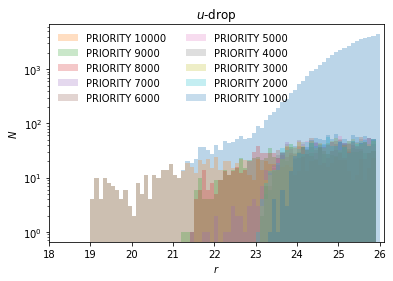

In [142]:
utiers = reduce(rlim_udrops, 'r', 'u', maglim=26.01, write=True)

In [108]:
utiers

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT,u-g,g-r,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int32,str8,int64,float64,float32,float32,float32,float32
2491,149.45330567667767,2.9018415068019565,10054,"0,0",0,7,True .. False,0.00018548353,0.00016953885,4.0,-33.30003,1.0941834,0.08607644,0.018092057901428732,0.00017292662,20.762558,0.9822748303413392,0.90322274,1.3562417,1.7694334,23.577,23.497,21.812,21.325,21.202,21.009,20.743,-99.022,-99.016,-99.01,-99.007,0.017,0.018,0.003,0.003,0.003,0.004,0.008,-99.0,-99.0,-99.0,-99.0,23.994144,23.953358,22.162415,21.602896,21.450367,21.216099,20.998728,1e+20,1e+20,1e+20,1e+20,0.009408648,0.010506639,0.0017844205,0.0016233062,0.0017346988,0.0020614814,0.0041527664,1e+20,1e+20,1e+20,1e+20,127.0,-10.905,-12.96,-15.084,-15.391,-16.587,-16.951,-17.105,-17.403,-17.472,-17.492,-17.534,-17.682,-17.458,-99.0,0.0922,0.0953,0.1006,7,212.509,137.92,61.6533,3,85,30,0.0978,0.0842,0.1128,-99.0,3.06,10,1015190000.0,0.1,1,1000060000.0,8.34998,8.3223,8.31596,8.38399,-3.90005,-3.87141,-3.96808,-3.83202,-12.2,-12.1937,-12.2681,-12.132,6.97738,7.86388,7.07106,2.0,1,0.0978,1.7650000000000006,0.4870000000000019,10000,11155,CLAUDS-U,0,0.0556634051984638,0.0,0.0,0.0,0.0
2672,149.5730242317071,2.905568388376073,10054,"0,0",0,7,True .. False,0.0010690697,9.007976e-05,4.0,0.768085,11.8764715,0.9157999,0.016955649074894812,0.0018626817,25.785202,0.004554886370897293,49.437374,47.548584,45.659794,27.557,26.257,23.745,22.882,24.702,22.908,23.88,-99.021,-99.015,-99.01,-99.006,0.945,0.403,0.032,0.023,0.153,0.041,0.185,-99.0,-99.0,-99.0,-99.0,29.838587,99.0,26.409311,25.524652,27.668121,25.602566,26.00821,1e+20,1e+20,1e+20,1e+20,1.6607386,99.0,0.084408276,0.058001798,0.5062971,0.10896616,0.30050775,1e+20,1e+20,1e+20,1e+20,127.0,-22.823,-21.832,-21.337,-21.344,-21.238,-21.006,-20.839,-20.767,-20.714,-20.679,-20.508,-20.305,-19.907,-99.0,3.4898,3.

# BX selection

In [99]:
def bx(cat, rmin=19., rmax=24.5):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = np.ones(len(cat), dtype=bool)

    cat['u-g'] = cat['u'] - cat['g']
    cat['g-r'] = cat['g'] - cat['r']
    
    # LATIS, https://arxiv.org/pdf/2002.10676.pdf
    # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
    isin &= cat['u-g'] >  0.0
    isin &= cat['u-g'] <  3.0
    isin &= cat['g-r'] > -0.5
    isin &= cat['g-r'] <  1.0
    isin &= cat['u-g'] >  1.0 + 2.3 * (cat['g-r'] - 0.35)

    # isin &= ((cat['g-r'] < 0.25) & (cat['u-g'] < 1.2)) | (cat['u-g'] >= 1.2)
    # isin &= ((cat['g-r'] < 0.15) & (cat['u-g'] < 1.0)) | (cat['u-g'] >= 1.0)
    
    isin  = isin & (cat['r'] > rmin)
    isin  = isin & (cat['r'] < rmax)
    isin  = isin & (~liu_udrops(cat, band='r', magmin=rmin, maglim=rmax))

    # Catch -99 for ill defined magnitudes
    isin = isin & (cat['u'] > 0.0)
    isin = isin & (cat['g'] > 0.0)
    
    return  isin

In [100]:
# not u-drops, by definition.
bx_clauds = clauds[bx(clauds, rmin=19., rmax=24.5)]

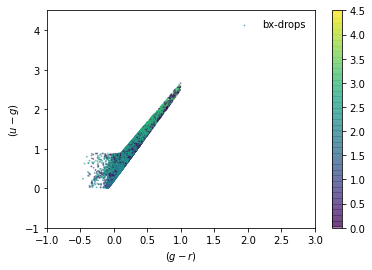

In [101]:
pl.scatter(bx_clauds['g'] - bx_clauds['r'], bx_clauds['u'] - bx_clauds['g'], marker='.', c=bx_clauds['Z_BEST'], alpha=0.5, label='bx-drops', vmin=0.0, vmax=4.5, s=3)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

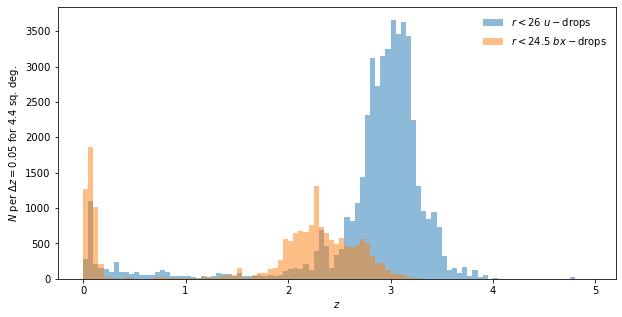

In [102]:
fig, axes = plt.subplots(1, 1, figsize=(10., 5.))
    
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

axes.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$drops')
axes.hist(bx_clauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<24.5$ $bx-$drops')

axes.set_xlabel(r'$z$')
axes.set_ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

axes.legend(frameon=False)

In [103]:
print('Target density of bx-dropouts per sq. deg. is {:.2f}'.format(len(bx_clauds) / area['u']))

Target density of bx-dropouts per sq. deg. is 3970.75


In [104]:
bx_interlopers = bx_clauds[bx_clauds['ZPHOT'] < 0.1]

In [105]:
print('BX interloper percentage of {:.3f}'.format(100. * np.count_nonzero(bx_clauds['ZPHOT'] < 0.1) / len(bx_clauds)))

BX interloper percentage of 12.786


Text(0, 0.5, '$(u-g)$')

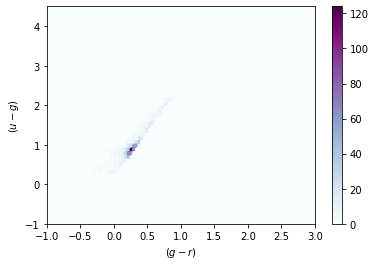

In [106]:
plt.hexbin(bx_interlopers['g'] - bx_interlopers['r'], bx_interlopers['u'] - bx_interlopers['g'], label='bx-drops', extent=[-1., 3., -1., 4.5], cmap='BuPu')
pl.colorbar()

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

In [148]:
start_id = len(utiers)
start_id

38456

20.0 	 1 	 2997	Adjusting 1997 entries.
20.0 	 2 	 1000

22.2 	 2 	 2590	Adjusting 1590 entries.
22.2 	 3 	 1000

22.9 	 3 	 2590	Adjusting 1590 entries.
22.9 	 4 	 1000

23.3 	 4 	 3522	Adjusting 2522 entries.
23.3 	 5 	 1000

23.5 	 5 	 4324	Adjusting 3324 entries.
23.5 	 6 	 1000

23.6 	 6 	 4678	Adjusting 3678 entries.
23.6 	 7 	 1000

23.7 	 7 	 4735	Adjusting 3735 entries.
23.7 	 8 	 1000

23.8 	 8 	 4632	Adjusting 3632 entries.
23.8 	 9 	 1000

23.9 	 9 	 4353	Adjusting 3353 entries.
23.9 	 10 	 1000

24.0 	 10 	 4003	Adjusting 3003 entries.
24.0 	 11 	 1000


-------------------------

13003 	 17511



     10000 	       1000 	 21.73 	 0.83
      9000 	       1000 	 21.65 	 0.72
      8000 	       1000 	 21.75 	 0.77
      7000 	       1000 	 23.27 	 1.62
      6000 	       1000 	 23.61 	 1.83
      5000 	       1000 	 23.75 	 1.94
      4000 	       1000 	 23.84 	 1.96
      3000 	       1000 	 23.93 	 2.02
      2000 	       1000 	 23.95 	 1.96
      1000 	       1000 	 23.99

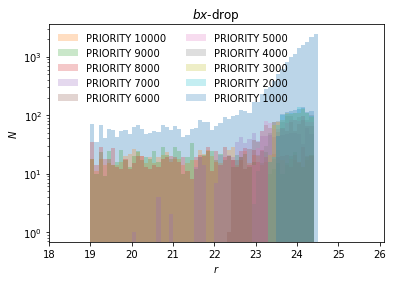

In [149]:
bxtiers = reduce(start_id, bx_clauds, 'r', 'bx', maglim=24.51, debug=False, write=True)

In [150]:
bxtiers

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT,u-g,g-r,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int32,str9,int64,float64,float32,float32,float32,float32
642,149.5595844300787,2.883241284620828,10054,"0,0",0,7,True .. False,0.00017157056,0.0001515909,4.0,-28.743399,1.1319381,0.116559446,0.01638653633604145,0.00029176884,24.115816,0.2947301268577576,1.2820113,1.8997669,2.4261932,24.777,24.729,24.218,24.105,23.872,23.652,23.471,-99.02,-99.014,-99.009,-99.006,0.033,0.038,0.019,0.024,0.023,0.031,0.055,-99.0,-99.0,-99.0,-99.0,25.146523,25.217518,24.661077,24.507526,24.191122,23.947348,23.886034,1e+20,1e+20,1e+20,1e+20,0.025261775,0.032501,0.016169598,0.019702375,0.017703168,0.022658268,0.045481786,1e+20,1e+20,1e+20,1e+20,127.0,-20.577,-20.899,-21.84,-22.069,-22.771,-23.176,-23.456,-23.634,-23.718,-23.743,-23.817,-23.986,-23.772,-99.0,2.0215,1.9744,2.1057,7,0.548576,97.3676,1.81216,28,238,29,2.0621,1.9874,2.1309,-99.0,0.7,3,1608980000.0,0.2,1,1730100000.0,10.8584,10.8332,10.3153,10.9787,1.49784,1.45,1.40807,1.8423,-9.40146,-9.38322,-9.55886,-8.50739,10.4182,10.5376,9.68393,0.0,0,2.0621,0.559000000000001,0.11299999999999955,10000,11155,CLAUDS-BX,38456,0.8595775778281888,0.0,0.0,0.0,0.0
1163,149.51144255922006,2.8863232132097987,10054,"0,0",0,7,True .. False,0.0003101514,0.00023002054,4.0,40.14685,1.3481488,0.25824213,0.0169516723932009,0.00063610286,23.188837,0.02773100696504116,2.2467184,3.3881872,4.40153,23.097,23.031,22.161,21.847,21.65,21.564,21.467,-99.021,-99.015,-99.01,-99.006,0.012,0.014,0.005,0.006,0.005,0.008,0.016,-99.0,-99.0,-99.0,-99.0,24.098652,24.09217,23.146397,22.735338,22.513407,22.3893,22.393408,1e+20,1e+20,1e+20,1e+20,0.009036499,0.011199202,0.0041292915,0.0042005884,0.0039348803,0.0055603688,0.012420296,1e+20,1e+20,1e+20,1e+20,127.0,-14.172,-14.116,-14.774,-14.968,-15.544,-15.806,-15.983,-16.096,-16.136,-16.144,-16.149,-16.223,-15.917,-99.

# Goldrush g-dropouts

In [162]:
clauds_hsc, area = get_clauds(imaging_bit=0, field='COSMOS')

In [163]:
def gdrop(cat, imin=18., imax=26.):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = np.ones(len(cat), dtype=bool)

    cat['r-i'] = cat['r'] - cat['i']
    cat['g-r'] = cat['g'] - cat['r']

    # https://arxiv.org/pdf/1704.06004.pdf
    isin &= cat['g-r'] >  1.0
    isin &= cat['r-i'] <  1.0    
    isin &= cat['g-r'] >  1.5 * cat['r-i'] + 0.8
    
    isin  = isin & (cat['i'] > imin)
    isin  = isin & (cat['i'] < imax)
    
    # Catch -99 for ill defined magnitudes
    isin = isin & (cat['g'] > 0.0)
    isin = isin & (cat['r'] > 0.0)
        
    return  isin

In [164]:
clauds_hsc

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
0,149.59750039856772,2.878867531391069,10054,"0,0",0,7,True .. False,5.983199e-05,4.2390246e-05,0.0,18.707382,1.411474,0.29152077,0.01650220434314842,0.00010493658,26.313028,0.35052329301834106,0.90521127,1.1155249,1.290297,28.618,28.469,28.224,28.454,28.143,27.342,-99.021,-99.02,-99.014,-99.009,-99.006,0.321,0.396,0.228,0.409,0.366,0.284,-99.0,-99.0,-99.0,-99.0,-99.0,28.174038,28.644983,28.512594,28.279272,29.47153,28.575283,99.0,1e+20,1e+20,1e+20,1e+20,0.28810936,0.6316033,0.40882772,0.48986953,1.7506987,1.2607428,99.0,1e+20,1e+20,1e+20,1e+20,63.0,-15.932,-15.841,-17.297,-17.537,-18.373,-18.848,-19.151,-19.347,-19.436,-19.465,-19.551,-19.735,-19.507,-99.0,1.3113,0.2992,2.4572,6,0.34828,2.74895,0.441968,26,242,18,1.5941,0.9272,2.2318,-99.0,1.88,12,3000000000.0,0.1,1,876443000.0,8.44477,9.20917,7.81413,9.03823,-0.425113,-0.824061,-0.894037,0.139983,-8.87912,-10.0332,-9.42886,-8.10284,8.151,8.5744,7.88058,0.0,0,1.5941
1,149.54307792888886,2.878899117842753,10054,"0,0",0,7,True .. False,9.388733e-05,4.5947952e-05,4.0,-4.1316705,2.0431647,0.51056325,0.016291514813532786,0.0003912516,25.518118,0.3872963190078736,0.9483222,1.2461437,1.4747574,27.574,28.053,28.085,27.543,26.89,26.906,26.839,-99.02,-99.014,-99.009,-99.006,0.123,0.259,0.198,0.173,0.114,0.186,0.371,-99.0,-99.0,-99.0,-99.0,27.541115,27.956047,27.778364,27.591347,26.928577,26.81956,27.107319,1e+20,1e+20,1e+20,1e+20,0.17674026,0.3514954,0.22487052,0.2763569,0.18269701,0.26761687,0.7439933,1e+20,1e+20,1e+20,1e+20,127.0,-15.423,-14.97,-15.817,-15.93,-16.142,-16.154,-16.172,-16.226,-16.245,-16.234,-16.149,-16.174,-15.916,-99.0,0.7557,0.6459,0.9068,7,2.46672,22.4587,3.58548,27,48,29,0.8746,0.6589,1.2486,-99.0,0.2,10,321031000.0,0.0,0,1198660000.0,7.7489,7.5288,7.45523,8.04443,-1.27257,-1.68193,-1.4498,-0.789413,-9.02023,-9.21073,-9.43064,-8.31573,7.50047,7.48196,6.54335,0.0,0,0.8746
2,149.51906824547063,2.878

In [166]:
ilim_gdrops = clauds_hsc[gdrop(clauds_hsc, imax=26.)]

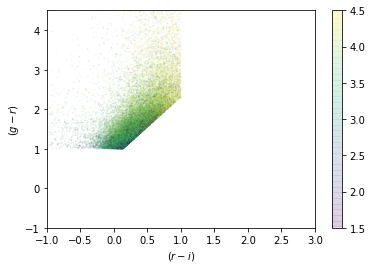

In [170]:
pl.scatter(ilim_gdrops['r'] - ilim_gdrops['i'], ilim_gdrops['g'] - ilim_gdrops['r'], marker='.', c=ilim_gdrops['Z_BEST'], alpha=0.1, label='', vmin=zmax, vmax=4.5, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(r-i)$')
pl.ylabel(r'$(g-r)$')

pl.colorbar()

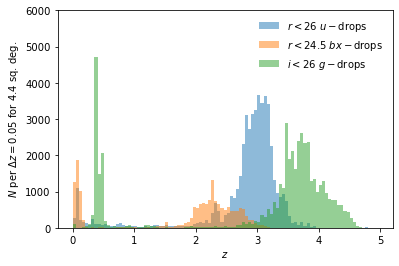

In [171]:
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

pl.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$drops')
pl.hist(bx_clauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<24.5$ $bx-$drops')
pl.hist(ilim_gdrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$i<26 \ g-$drops')

pl.ylim(0.0, 6.e3)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

pl.legend(frameon=False)

In [172]:
print('Target density of g-dropouts per sq. deg. is {:.2f}'.format(len(ilim_gdrops) / area['g']))

Target density of g-dropouts per sq. deg. is 5952.81


In [173]:
print('g-drop interloper percentage of {:.3f}'.format(100. * np.count_nonzero(ilim_gdrops['Z_BEST'] < 1.0) / len(ilim_gdrops)))

g-drop interloper percentage of 20.189


In [174]:
start_id = 1 + bxtiers['TARGETID'].max()
start_id

51459

21.6 	 1 	 547
21.6 	 1 	 547

23.3 	 2 	 1798	Adjusting 798 entries.
23.3 	 3 	 1000

24.0 	 3 	 6135	Adjusting 5135 entries.
24.0 	 4 	 1000

24.4 	 4 	 11681	Adjusting 10681 entries.
24.4 	 5 	 1000

24.7 	 5 	 18684	Adjusting 17684 entries.
24.7 	 6 	 1000

24.9 	 6 	 22991	Adjusting 21991 entries.
24.9 	 7 	 1000

25.0 	 7 	 24864	Adjusting 23864 entries.
25.0 	 8 	 1000

25.1 	 8 	 26141	Adjusting 25141 entries.
25.1 	 9 	 1000

25.2 	 9 	 26948	Adjusting 25948 entries.
25.2 	 10 	 1000

25.3 	 10 	 27457	Adjusting 26457 entries.
25.3 	 11 	 1000


-------------------------

36004 	 46670



     10000 	        547 	 23.16 	 2.32
      9000 	       1000 	 24.45 	 2.98
      8000 	       1000 	 24.47 	 3.03
      7000 	       1000 	 24.85 	 3.09
      6000 	       1000 	 24.84 	 3.05
      5000 	       1000 	 24.84 	 3.08
      4000 	       1000 	 24.79 	 3.16
      3000 	       1000 	 24.81 	 3.45
      2000 	       1000 	 25.05 	 3.12
      1000 	       1000 	 25.07 	 3.01
     

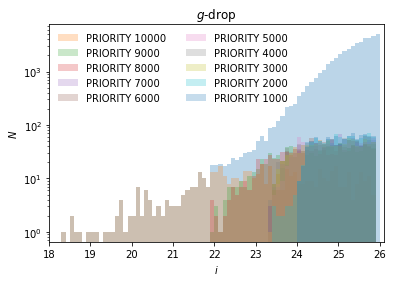

In [175]:
gtiers = reduce(start_id, ilim_gdrops, 'i', 'g', maglim=26.01, levels=10, debug=False, write=True)

In [177]:
gtiers

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT,r-i,g-r,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int32,str8,int64,float64,float32,float32,float32,float32
36881,149.52983216845223,3.2503503551336728,10054,"0,1",0,7,True .. False,0.00056679646,0.00037718998,4.0,-26.887407,1.5026112,0.33449185,0.026790271176207515,0.00027806568,23.102467,0.4462233781814575,1.8102975,2.9281704,4.131097,25.97,26.093,24.605,22.711,22.104,21.819,21.616,-99.032,-99.023,-99.015,-99.01,0.203,0.55,0.071,0.016,0.012,0.014,0.03,-99.0,-99.0,-99.0,-99.0,26.514511,27.221735,25.278053,23.75917,23.059092,22.671276,22.60003,1e+20,1e+20,1e+20,1e+20,0.08036054,0.37629303,0.03285404,0.010617228,0.007823856,0.008277481,0.019347358,1e+20,1e+20,1e+20,1e+20,127.0,-13.019,-13.63,-16.683,-17.032,-18.615,-19.227,-19.633,-19.908,-20.071,-20.126,-20.224,-20.435,-20.19,-99.0,0.3611,0.3461,0.3773,7,13.1901,56.4847,14.2534,2,102,27,0.3681,0.3475,0.3884,-99.0,3.52,21,8000000000.0,0.0,0,7077530000.0,9.8625,9.88551,9.78259,9.92785,-2.43565,-2.30891,-4.53694,-2.0496,-12.4951,-12.1944,-16.8146,-11.9702,6.88643,8.65392,8.21011,0.0,0,0.3681,0.6069999999999993,1.894000000000002,10000,11155,CLAUDS-G,51459,0.8345363408029215,0.0,0.0,0.0,0.0
38352,149.542796272004,3.2447488601907053,10054,"0,1",0,7,True .. False,0.000101710844,8.8725916e-05,4.0,-64.24882,1.1464735,0.12776011,0.026256971953308512,0.0005694734,25.681519,0.5484663248062134,1.1853384,1.6592895,2.0842392,28.861,-99.123,27.108,25.971,25.781,25.674,26.292,-99.032,-99.023,-99.015,-99.01,0.86,-99.0,0.186,0.09,0.101,0.138,0.596,-99.0,-99.0,-99.0,-99.0,31.545437,99.0,27.353428,26.184988,25.92839,25.95627,26.239214,1e+20,1e+20,1e+20,1e+20,8.649367,99.0,0.20404151,0.09726725,0.1051566,0.16398376,0.5227475,1e+20,1e+20,1e+20,1e+20,125.0,-19.97,-20.133,-21.074,-21.299,-21.812,-21.926,-21.997,-22.052,-22.063,-22.053,-21.969,-22.007,-21.728,-99.0,3.1084,2.9676,4.12

Text(0.5, 1.0, 'Clauds COSMOS: (150.1370, 2.2022)')

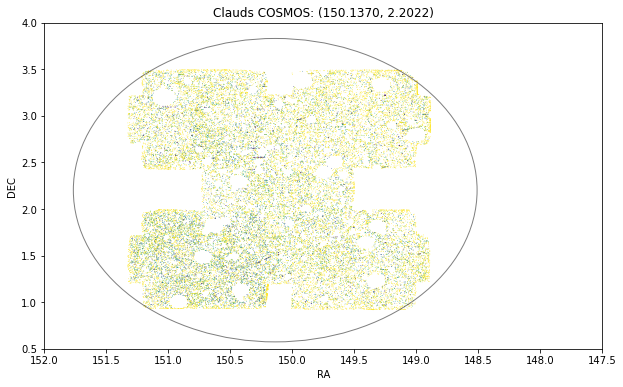

In [178]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(utiers['RA'], utiers['DEC'], c=utiers['u_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

# cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
# fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

Text(0.5, 1.0, 'Clauds COSMOS: (150.1370, 2.2022)')

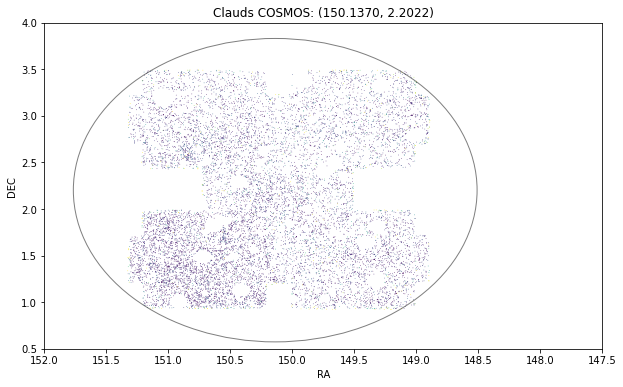

In [179]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(bxtiers['RA'], bxtiers['DEC'], c=bxtiers['u_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

Text(0.5, 1.0, 'Clauds COSMOS: (150.1370, 2.2022)')

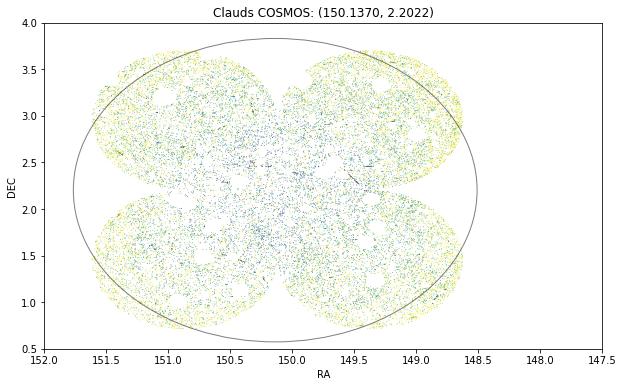

In [180]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(gtiers['RA'], gtiers['DEC'], c=gtiers['g_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

# Done.